# GANs and Variational Encoders

In these notes, we will talk about generative adversarial networks and variational encoders. These notes are taken while studying the course [Deep Learning: GANs and Variational Encoders](https://www.udemy.com/course/deep-learning-gans-and-variational-autoencoders/).

The cool stuff about GANs is they can learn the features of unlabaled data. For instance, by using the face generation task on GANs, we can learn which feature controls age, facial expression, etc.

This course is separated to there different parts:
1. Generative Modelling: This is a review of Bayesian concepts and latent variable models. Basically it's a summary of generative models without deep learning. Variational GMM will be demonstrated in this section.

2. Variational Encoders: The latent space variations and variational encoders will be demonstrated.

3. GANs: Generative Models will be built on what we learnt in previous chapters.

## Generative Modeling Review

We know how to sample from a random variable. In this section, we will move forward to one step further: We will sample from a learnt classifier.

### Bayes Classifier
- For each class $y$, we model $p(x | y)$, rather than directyly modelling $p(y | x)$
- _"Generative Models"_ is very appropriate in this case, as we'll be using it to generate samples
- Multiple ways to learn $p(x | y)$
- Easy way: $p(x|y) = N(\mu_{y'}, \Sigma_y)$

In order to sample from a Bayes Classifier:

1. Find all training data $x$ belongs to class $y$
2. $\mu_y = mean\;of\;x's$
3. $\Sigma_y = variance\;of;x's$
    - _Classification decision rule:_

$$argmax_y\;p(y|x) = argmax_y\frac{p(x|y) p(y)}{p(x)}$$

#### Sampling from Bayes Classifier

__METHOD 1:__
- Pick a class
- We know $p(x | y = 1)$ is a Gaussian (we've defined in that way)
- Sample from this Gaussian by using a library

__METHOD 2:__
- We have a graphical model
- Each node represents a distribution
- _Key 1:_ y has its own distribution
- __Fitting:__ $p(y==k) = \#\;images\;of\;digit\;k$ 
- _Key 2:_ Since we ahve a $p(y)$, we can sample from it


In [ ]:
# importing libraries
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from scipy.stats import multivariate_normal as mvn
from sklearn.mixture import BayesianGaussianMixture

In [151]:
# fetching the MNIST dataset for classifier

mnist_dataset = datasets.MNIST(root = "/home/adm1n/Datasets/torchvision", transform=transforms.PILToTensor(), download=True)
mnist = DataLoader(mnist_dataset, batch_size=64, shuffle=True, num_workers=0)

In [51]:
# implementing the Bayes Classifier

class BayesClassifier:
    num_classes = None
    gaussians = []
    
    def fit(self, X: np.ndarray, Y: np.ndarray):
        self.num_classes = len(set(Y))
        
        for k in range(self.num_classes):
            X_k = X[Y == k]
            mean = X_k.mean(axis=0)
            cov = np.cov(X_k.T)
            self.gaussians.append({"mean": mean, "covariance": cov})

    def sample_given_y(self, y: int):
        gaussian = self.gaussians[y]
        mean, cov = gaussian["mean"], gaussian["covariance"]
        return mvn.rvs(mean=mean, cov=cov)

    def sample(self):
        y = np.random.randint(self.num_classes)
        return self.sample_given_y(y)

In [152]:
# collecting the X and Y from MNIST dataset
torch.multiprocessing.set_sharing_strategy('file_system')

X = list()
Y = list()
for data in mnist:
    X.append(data[0])
    Y.append(data[1])

X = torch.cat(X, dim=0).squeeze(dim=1).numpy()
Y = torch.cat(Y, dim=0).numpy()
print(X.shape)
print(Y.shape)

(60000, 28, 28)
(60000,)


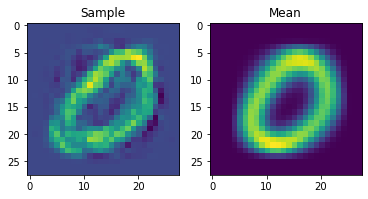

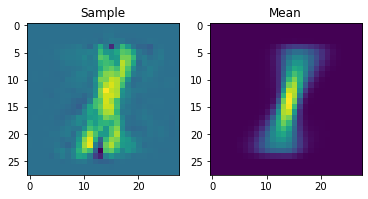

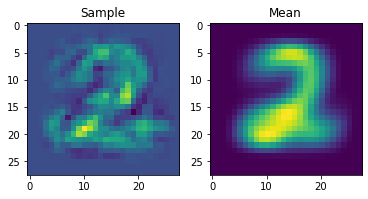

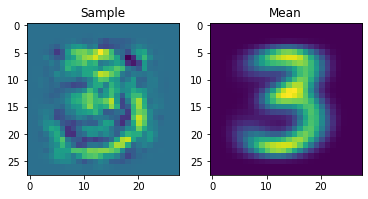

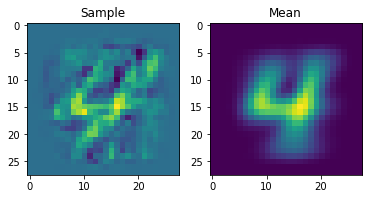

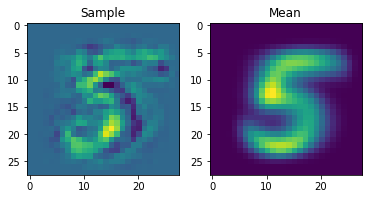

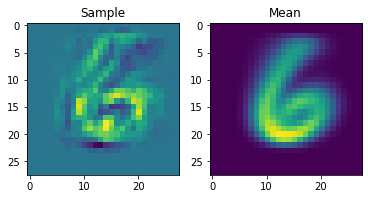

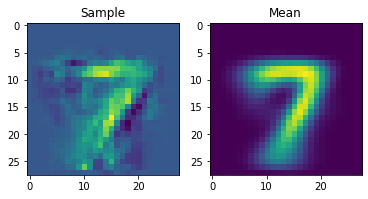

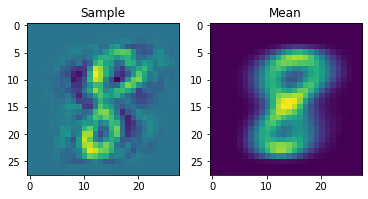

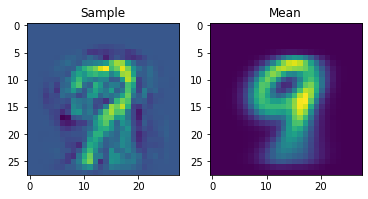

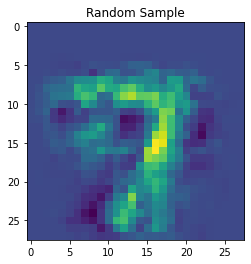

In [53]:
classifier = BayesClassifier()
classifier.fit(X.reshape((X.shape[0], - 1)), Y)

for k in range(classifier.num_classes):
    sample = classifier.sample_given_y(k).reshape(28, 28)
    mean = classifier.gaussians[k]["mean"].reshape(28, 28)
    
    plt.subplot(1, 2, 1)
    plt.imshow(sample)
    plt.title("Sample")
    plt.subplot(1, 2, 2)
    plt.imshow(mean)
    plt.title("Mean")
    plt.show()

plt.imshow(classifier.sample().reshape(28, 28))
plt.title("Random Sample")
plt.show()

### Extending our Bayes Classifier

In our previous Bayes Classifier on MNIST dataset, single Gaussian model learns blurry images. What is the reason for that?
- We tried to force a single Gaussian to fit a multi-modal distribution.

Since everyone writes the digits in a different way. Hence, each digit has different multi-modal distributions inside. However, in previous example, we tried to modal each digit with a single Gaussian, which creates the blurry samples.

Then, the question is _how can we model a multi-modal distribution_?
- We can do this by using Gaussian Mixture Models.

If you want to learn mathematical background of Gaussian Mixture Models, please follow the link [here](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95). For this course, we will use a pre-built GMM from scikit learn library.

The important thing about GMM is it can fit multiple Gaussians in different proportions to approximate a multi-modal distribution.

__Interesting facts about GMMs:__
- GMM is a _latent variable_ model, and unsupervised learning is al about latent variables.
- We call the latent variable $z$ - _it represents "which cluster $x$ belongs to"_
- $p(z)$ is the prior probability that any $x$ belongs to a cluster. It tells us, without looking at any $x$, which cluster you're likely to belong to.
- $p(x | z)$ is a Gaussian

__IMPORTANT NOTE:__ $p(z)$ is not the same as $p(z | x)$

Analogy: 
- $p(z)$ = frequency of disease in a population
- $p(z | x)$ = patient goes to doctor's office and performs a test

If you're wondering why all of these are important, the reason is variational inference is a key component of a variational encoders and variation inference can be seen as a Bayesian extension of Expectation-Maximization algorithm used for GMM.

One weakness of K-Means clustering and GMMs is we have to choose the number of clusters. If we choose wrong, than model is bad. However, the variational inference version of GMM contains an infinite number of clusters. Hence, VI-GMM autmatically find the number of clusters for you.

In [68]:
# implementing the Bayes Classifier for multi-modal distribution

class BayesClassifierGMM:
    num_classes = None
    gaussians = []
    
    def fit(self, X: np.ndarray, Y: np.ndarray):
        self.num_classes = len(set(Y))
        
        for k in range(self.num_classes):
            X_k = X[Y == k]
            gmm = BayesianGaussianMixture(n_components=8, verbose=1)
            gmm.fit(X_k)
            self.gaussians.append(gmm)

    def sample_given_y(self, y: int):
        gmm = self.gaussians[y]
        return gmm.sample()[0]

    def sample(self):
        y = np.random.randint(self.num_classes)
        return self.sample_given_y(y)

Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


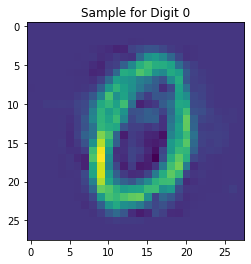

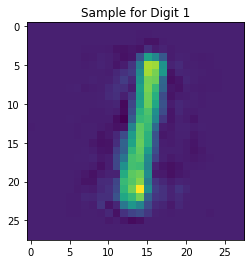

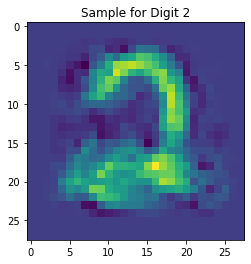

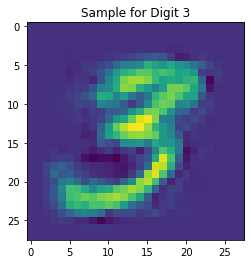

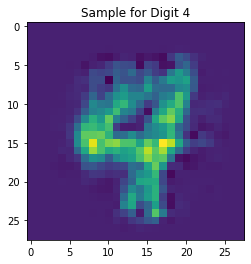

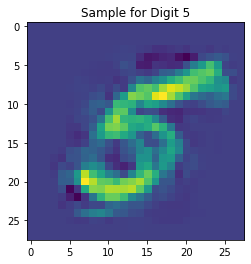

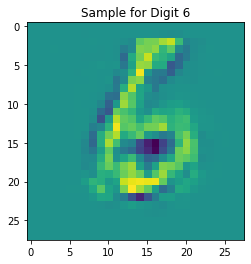

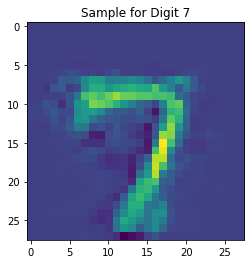

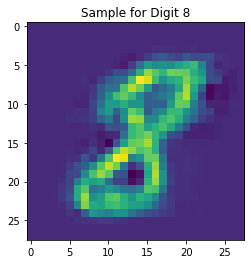

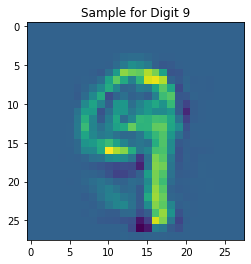

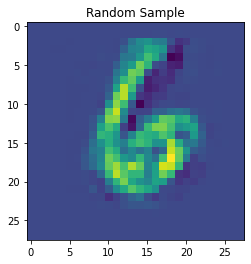

In [69]:
classifier = BayesClassifierGMM()
classifier.fit(X.reshape((X.shape[0], - 1)), Y)

for k in range(classifier.num_classes):
    sample = classifier.sample_given_y(k).reshape(28, 28)
    
    plt.imshow(sample)
    plt.title("Sample for Digit {}".format(k))
    plt.show()

plt.imshow(classifier.sample().reshape(28, 28))
plt.title("Random Sample")
plt.show()

As you can see, the generated samples are a little better than the ones before.

## Variational Encoders

Variational encoder is a neural network that learns and reproduce its input. However, the important thing in here is it can map data to latent space and generate samples from this latent space.

The word variational refers to _"variational inference"_. If you want to get a deeper understanding for variational encoders, you can learn these probability topics to broaden your perspective.

### Architecture

Variational encoders are a little different than traditional autoencoders. At the end of the encoder part, something strange happens. Since the Bayesian machine learning is all about learning distibutions, not learning point estimates, we are finding the distribution of latent space. Also, just before the decoder part, from the distribution of this latent space, a sample is drawn and this sample is decoded.

Since the output of the encoder is a distribution, it's going to affect how we use it.

### Parametrizing a Gaussian

We can parametrize a Gaussian in different methods. For this notes, we will use axis-aligned Gaussian (one variance parameter per dimension) rather than a full covariance Gaussian (requires full DxD matrix). A one dimensional Gaussian can be represented by two numbers: mean and variance and the neural network output will give this parameters.

- One important part is that the variance is a strictly positive number. In order to satisfy this condition, we can use softplus activation function at the end of the encoder.

### Cost Function
- Machine learning models typically have 2 functions we're interested in: learning and inference
- _"Inference"_ - too broad and overused, but generalizes the concept of the "forward" direction

Inference means prediction in supervised learning perspective and, in the context of unsupervised learning, it means transforming data into the latent representation. Hence, the next step is fitting or learning the parameters. In order to do that, we need to define a cost function to minimize.

The objective function we minimize is called as __"ELBO" - evidence lower bound__. However, we want to maximize the ELBO, therefore our "cost" function will be the negative of ELBO.

ELBO consists of two terms: Expected log likelihood of the data minus the sclae divergence between $q(z|x)$ and $p(z)$:

$$ ELBO = E[log(p(x|z)] - D_{KL}[q(z|x) || p(z)] $$

__Expected Log-Likelihood:__ It's a different way to do what we usually do: Cross entropy loss. If $x$ and $\hat x$ are Bernoulli probabilities, this becomes binary cross-entropy. If the input and outputs are Gauissian, then the cross-entropy is squared error + some constants. Hence, in fact, these are just the same reconstruction losses.

__KL Divergence:__ In Bayesian machine learning we call $p(z)$ the _"prior"_, it is up to us to choose it. For convenience, we choose $p(z) = N(0, 1)$. Weakness of Bayesian machine learning is that a poorly choosen prior can lead to bad results in good model.

$$ D_{KL}[q(x) || p(x)] = \int q(x)log \frac{q(x)}{p(x)}dx $$

This allows us to compare 2 probability distributions. If $q = p$ then KL divergence is zero and the higher the difference between $q$ and $p$, the higher KL divergence for these distributions.

Hence, the first part of the loss function tells us how close our output is to target (we always have this, whether we are doing classification, regression or reconstruction input) and the second part is regularization penalty for the prior distribution of latent space and current input.

In [137]:
# implementation a variational encoder for MNIST

class VariationalEncoder(nn.Module):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kl_div = None
    
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Linear(28*28, 256, bias=False),
            nn.LeakyReLU(),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(),
            nn.Linear(128, 128, bias=False),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128, bias=False),
            nn.LeakyReLU(),
            nn.Linear(128, 256, bias=False),
            nn.LeakyReLU(),
            nn.Linear(256, 28*28, bias=False)
        )
        
        self.softplus = nn.Softplus(threshold=1)
        self.to(self.device)


    def forward(self, tensor):
        latent = self.encoder(tensor / 255.0)
        latent_mean = latent[..., :64]
        latent_variance = self.softplus(latent[..., 64:])
        self.kl_div = (latent_variance**2 + latent_mean**2 - torch.log(latent_variance) - 0.5).mean()
        
        latent_space = torch.distributions.Normal(latent_mean, latent_variance)                  
        sample = latent_space.rsample()
        return self.decoder(sample) * 255.0

In [179]:
# implementation of training function for variational encoder
def train_encoder(encoder: VariationalEncoder, epoch_num = 20):
    optimizer = optim.Adam(encoder.parameters(), lr=0.0001, weight_decay=1e-5)
    mse_loss = nn.MSELoss()
    bar = tqdm.tqdm(range(1, epoch_num + 1))
    losses = []
    
    for iter_num in bar:
        total_loss = 0.0
        iteration = 0
        for data in mnist:
            X = data[0].squeeze(dim=1).view(-1, 28*28).float().to(encoder.device)

            output = encoder(X)
            loss = mse_loss(X, output) + encoder.kl_div
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            iteration += 1
            bar.set_postfix({"Loss": "{:2.6f}".format(total_loss/iteration)})
        losses.append(total_loss/iteration)
    plt.plot(losses)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.11s/it, Loss=586.819362]


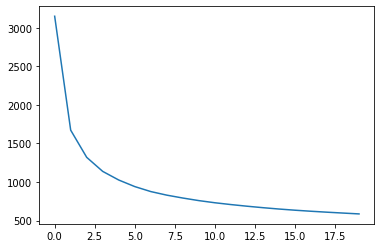

In [180]:
encoder = VariationalEncoder()
train_encoder(encoder)

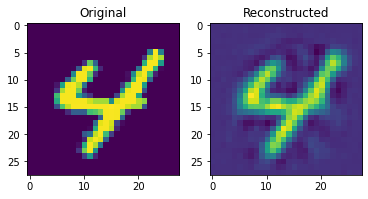

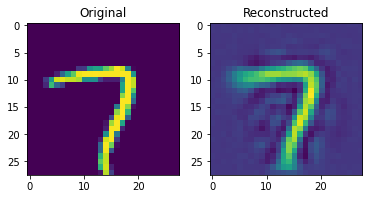

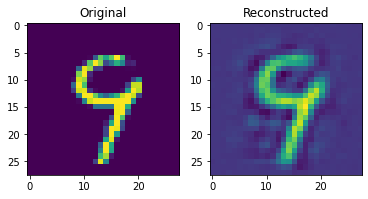

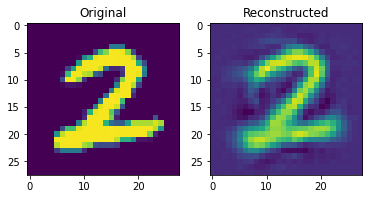

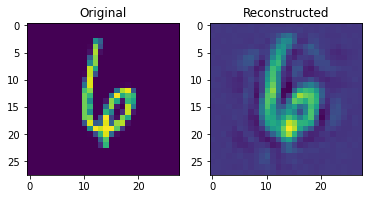

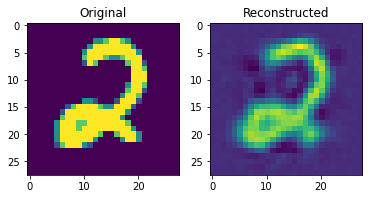

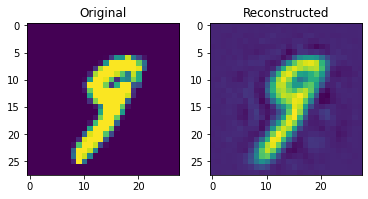

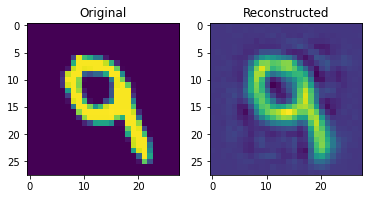

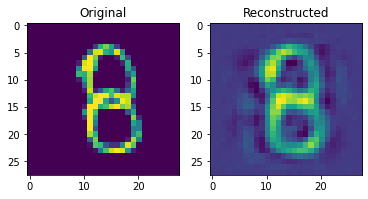

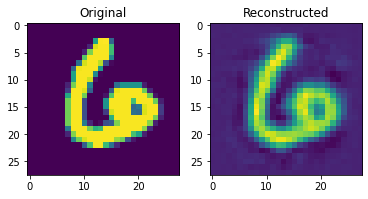

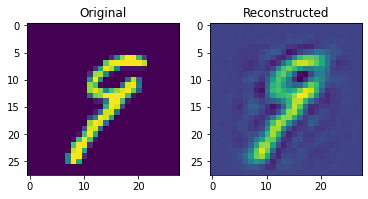

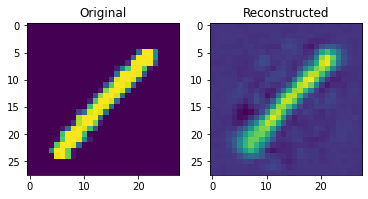

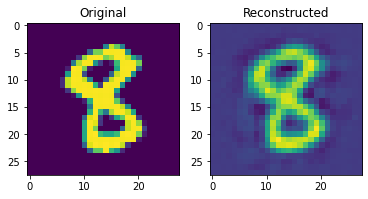

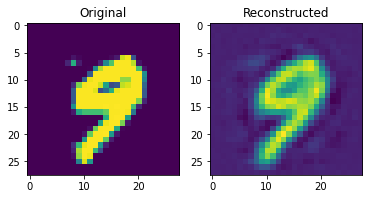

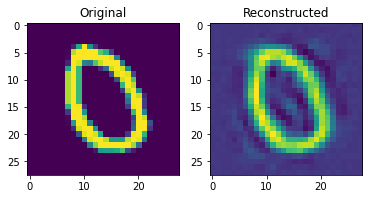

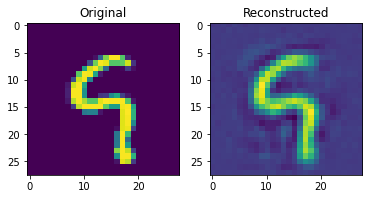

In [191]:
for data in mnist:
    X = data[0].squeeze(dim=1).view(-1, 28*28).float()
    out = encoder(X.to(encoder.device)).cpu()
    img = X.view(-1, 28, 28).numpy()
    img_ = out.view(-1, 28, 28).detach().numpy()
    for i in range(16):
        plt.subplot(1, 2, 1)
        plt.imshow(img[i])
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(img_[i])
        plt.title("Reconstructed")
        plt.show()
    break

### Reparametrization Trick

We know that if we generate a random variable by using _numpy.random.rand_, we obtain a random sample from Gaussian $N(0, 1)$. Also, we know that, if we normalize another sample, we can do it like:

$$ x_{normalized} = \frac{x - \mu_x}{\sigma} $$

If we rearange the terms, we get:

$$ x = \mu_x + \sigma_x x_{normalized} $$

which means that, we can obtain the sample by sampling one number from a normal distribution. By using this structure, we can create a sample in latent space easier and now we can differentiate this new variable with respect to parameters $\theta$.

## Generative Adverserial Networks (GANs)

This topic is considered as one of the most interesting developments in 21th century. GANs are extremely good at generating realistic, believable samples.

> Goal when training a GAN is to reach Nash equilibrium of a game

We know GANs produce better samles than variational encoders, but no number tell us this. We just have to use our senses!

### How o GANs work?

There are two different networks in GAN architecture. One of them is _"Generator Network"_ and _"Discriminator Network"_ and the idea is that these two neural networks are going to duel with each other. Generator networks job is fooling the discriminator by creating more realistic, indistinguishable samples. The discriminators job is classifiying whether the sample is real or generated.

![](images/image4.png)

### Cost Function
- We have 2 neural networks, so should we have 2 cost functions?

The generator and discriminator are trying to optimize the "opposite" thing. Let's start with the discriminator, since classification (supervised learning) is conceptually easier. Discriminators objective is classifying an image as "real" or "fake". Since there is two different labels, it's a binary classification problem. Then the lost function for binary classification is binary cross entropy:

$$ J = -[t logy + (1-t)log(1-y)] $$

wherer $t=1$ means the image is real and $t=0$ means the image is fake. Let

$$ y = D(x; \theta_D) $$

Then, by getting rid of the target $t$ we get:

$$ J^{(D)} = -logD(x) - log(1-D(\hat x)) $$

where $\hat x$ represents the fake images.

Now let's consider the generator part. $z$ represents the latent prior for variational encoders: $z \sim p(z)$. We need two steps to sample:
1. $z \sim p(z)$
2. $\hat x = G(z) $

where the $G$ represent the generator, and show parameters of G explicitly: $G(z; \theta_G)$. Now that, we have some notation for discriminator $D$ and generator $G$, we can state the cost function differently:

$$ J^{(D)} =  -logD(x) - log(1-D(G(z))) $$

Since, we will be looking at batches of data during tranining, so summing the individual negative log-likelihoods gives us the total cost:

$$ J^{(D)} =  -\sum_xlogD(x) - \sum_zlog(1-D(G(z))) $$

We find the total cost but the cost for generator will be negative for the generator:

$$ J^{G} = - J^{D} $$

__PROBLEM:__ If we consider the loss function from the generator perspective, then we get that the $G(z)$ part never occured at the left part of the equation. On the other hand, let's say the discriminator does a very good job. This time, $(D(G(z))$ becomes zero which cause that the parameters of the generator won't be updated. This is a problem!

To solve this problem, we can flip the target. Instead of a target 0 for fake images, the generator wants the target to be 1 and the loss function becomes:

$$ J^{(D)} =  -E[logD(G(z))] - E[log(1-D(x))] $$

$$ J^{(G)} =  -E[logD(G(z))] $$

Also, now since $J^{(G)} + J^{(G)} \neq 0$, this is no longer a zero-sum game. Any theoretical analysis done on such a game no longer applies. You may see this "fixed" generator cost referred to as a __"non-saturating heuristic"__.
- _Non-saturating_ $\rightarrow$ gradient doesn't converge to some value
- _Heuristic_ $\rightarrow$ no theoretical (probabilistic) reasoning, just solves a numerical issue

![](images/image5.png)

### DCGAN

One very successful type of GAN was created in 2015, called DCGAN and most GANs today are based on this. It's notable for producing high-quality, high-resolution images in a single pass. Its name stands for "Deep Convolutional" GAN. However, other GANs are also deep and contains convolution. Some specific characterizations of DCGAN are:
- Batch normalization
- It's a all convolutional netwoork (no pooling or linear layers)
- It uses Adam optimizer
- Leaky RELU solves the problem of dead neurons

> __Reminder for Adam optimizer:__
> $$ t \leftarrow t + 1 $$

> $$ m_t \leftarrow \beta_1m_{t-1} + (1-\beta_1)g_t $$

> $$ v_t \leftarrow \beta_2v_{t-1} + (1- \beta_2)g_t^2 $$

> $$ \eta_t \leftarrow \eta_0 \frac{\sqrt{1-\beta_2^t}}{1 - \beta_1^t} $$

> $$ \theta_t \leftarrow \theta_t - \eta_t \frac{m_t}{\sqrt{v_t} + \epsilon} $$

> where $g_t$ is the gradient

### Deconvolution

It's a poor naming. It's a different from any other neural network layer. With regular convolution, we always get something ~same size or smaller size if stride is greater than 1. Normally, there is no way to add more information in to an image by increasing the size; however, for the bottleneck of the models, there is lots of channels and we can increase the size by decreasing the channel size. How do we perform an operation like this?

__Fractionally-Strided Convolution:__ If we use stride 2, the result is half of the original. Otherwise, if we use a stride of $\frac{1}{2}$, then result is double of the original. Deconvolution is not a good name since still it's a different type of convolution.

The implementation of the DCGAN was done in a separate file in folder _"examples"_. 